# Boeuf: comparisons of the specta

In [1]:
# Scientific libraries
import numpy as np
import scipy


# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib widget

plt.style.use("presentation")
plt.rcParams["figure.figsize"] = (4, 3)

# Creating alias for magic commands

# LPPview Classes
from LPPview import *
from LPPview.Classes.LPPic_temporal import History
from LPPview.Classes.LPPic_fields import field
from LPPview.Classes.LPPic_fields import field as Field
from LPPview.Classes.LPPic_newwalls import newwalls as Newwalls
from LPPview.Classes.LPPic_temporal import History

from plasmapy.physics import Debye_length
from plasmapy.physics import plasma_frequency
from astropy import units as u

from plasmapy.physics import Debye_length
from plasmapy.physics import plasma_frequency
from astropy import units as u

def get_lde_wpi(f):
    
    ne_vect = f.meanfield("Nume", "x")
    Te_vect = f.meanfield("Eke(1)", "x")
    wpi_vect = plasma_frequency(ne_vect/u.m**3, particle="Xe+")
    lDe_vect = Debye_length(Te_vect*u.eV, ne_vect/u.m**3,)

    return wpi_vect, lDe_vect

In [2]:
path_ref = "/DATA/tavant/266_Boeuf_166Thomas/"
path_L2 = "/DATA/tavant/158_Beauf_fakeR/"
path_L4 = "/DATA/tavant/163_Beauf_fakeR2/"
paths = [path_ref, path_L4, path_L2]
names = ["no $L_R$", "$L_R$=4cm", "$L_R$=2cm"]
colors = ["k","b", "r"]
fields = [Field(path) for path in paths ]
histories = [History(path)for path in paths ]
walls = [Newwalls(path) for path in paths ]



found 498 files
found 403 files
found 772 files
I've found a temporale file !
found 1 files
loading dat file
I've found a temporale file !
found 1 files
loading dat file
I've found a temporale file !
found 1 files
loading dat file
found 497 files
found 402 files
found 771 files


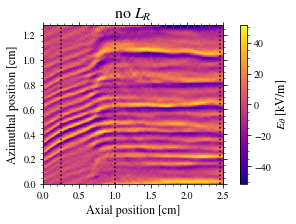

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

vmax = 0
i = 0
f = fields[i]
n = names[i]
tab = f.return_fromkey(-1, "Ej(1)")*1e-3
vmax = max(vmax, np.abs(tab).max())

tab = f.return_fromkey(-1, "Ej(1)")*1e-3
fig = ax.imshow(tab, extent=(0,f._Ly*100, 0, f._Lx*100), aspect="auto", vmin=-vmax, vmax=vmax)
ax.set_title(n)
    
ax.set_xlabel("Axial position [cm]")
        
ax.set_ylabel("Azimuthal position [cm]")
cb = plt.colorbar(fig, ax=ax, fraction=0.05, aspect=30)
cb.ax.set_ylabel("$E_{\\theta}$ [kV/m]")

ax.vlines(50*f._dX*100, 0, f._Lx*100, linewidth=1.5, linestyle=":")
ax.vlines(200*f._dX*100, 0, f._Lx*100, linewidth=1.5, linestyle=":")
ax.vlines(490*f._dX*100, 0, f._Lx*100, linewidth=1.5, linestyle=":")

plt.savefig("Boeuf_Ex_snapshot_positions.png", dpi=400)

## Spectra comparaison

In [4]:

import sys, os
class mute():
    def __enter__(self):
        self.tmp = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, *args):
        sys.stdout = self.tmp

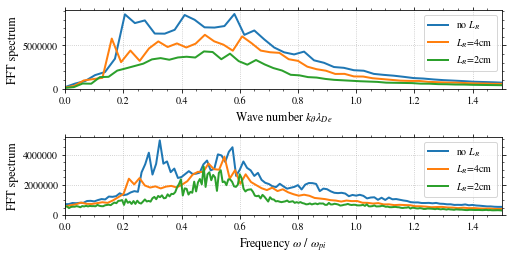

In [6]:
def get_spectra(run, yindex):
    """compute the spectrum"""
    
    with mute():
        tab = run.return_cut2d("Ej(1)", "y", position=yindex/run._ymax)
        
        wpi_vect, lDe_vect = get_lde_wpi(run)

    tab_2D = tab.T[:, 200:]

    Nx, Ny = tab_2D.shape

    Nx_fft, Ny_fft = Nx//2, Ny//2

    wavevect = np.fft.fftfreq(Nx, run._dX*1000)[:Nx_fft]
    frecvect = np.fft.fftfreq(Ny, run._dT*run._Na*1e6)[:Ny_fft]

    lde = lDe_vect[110].to(u.mm).value
    wpi = (wpi_vect[110]/u.rad*1e-6).value

    kvect = wavevect*2*np.pi
    wvect = frecvect*2*np.pi
    argfft2d = np.abs(np.fft.fft2(tab_2D, norm="ortho"))

    selectron_toplot = argfft2d[:Nx_fft, :Ny_fft].T

    mask = selectron_toplot < 1e1
    selectron_toplot[mask] = 0

    fft_wavenumber = selectron_toplot.mean(axis=0)
    fft_freqencies = selectron_toplot.mean(axis=1)
    
    return fft_wavenumber, fft_freqencies, kvect, wvect, lde, wpi


def fft_1D(yindex_min, yindex_max):
    """Compute the 1D fft on """
    
    mainFig, [axHistx, axHisty] = plt.subplots(2, figsize=(7, 3.5), facecolor='white')

    for f, n in zip(fields, names):
        fft_wavenumber, fft_freqencies, kvect, wvect, lde, wpi = get_spectra(f, yindex_min)
        for i in range(yindex_min+1,yindex_max):
            fft_wavenumber_tmp, fft_freqencies_tmp, _, _, _, _ = get_spectra(f, i)

            fft_wavenumber += fft_wavenumber_tmp
            fft_freqencies += fft_freqencies_tmp


        axHistx.plot(kvect*lde, fft_wavenumber, label=n )

        axHisty.plot(wvect/wpi, fft_freqencies, label=n )
    
    axHistx.set_xlim(0, 20)
    axHistx.set_xlim(0, 1.5)
    axHistx.set_ylim(0)
    axHisty.set_xlabel("Frequency $\\omega$ / $\\omega_{pi}$")
    axHistx.set_xlabel("Wave number $k_{\\theta} \lambda_{De}$")

    axHisty.set_xlim(0, 60)
    axHisty.set_xlim(0, 1.5)
    axHisty.set_ylim(0)
    
    for ax in [axHistx, axHisty]:
        ax.set_ylabel("FFT spectrum")
        ax.legend()
                  
    # Remove axis spines
    # axHistx.spines['top'].set_visible(False)
    # axHistx.spines['right'].set_visible(False)
    # axHistx.spines['left'].set_visible(False)
    # axHisty.spines['top'].set_visible(False)
    # axHisty.spines['bottom'].set_visible(False)
    # axHisty.spines['right'].set_visible(False)

    # remove ticks
    # axHistx.set_xticks([])
    # axHistx.set_yticks([])
    # axHisty.set_xticks([])
    # axHisty.set_yticks([])

    return mainFig, axHistx, axHisty



mainFig, axHistx, axHisty = fft_1D( yindex_min=200, yindex_max=480)

plt.savefig("Beuf_spectra_comp.pdf")

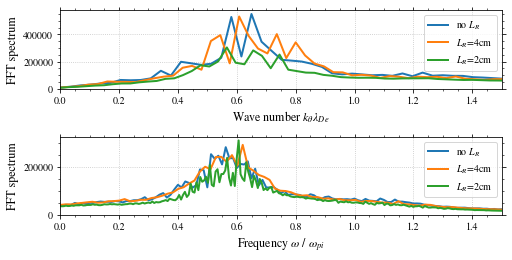

In [8]:


mainFig, axHistx, axHisty = fft_1D( yindex_min=100, yindex_max=120)

plt.savefig("Beuf_spectra_comp_upstream.pdf")